# Задание №7

### Метод случайного поиска

In [3]:
import numpy as np

In [669]:
def f(x):
    x_1 = x[0]
    x_2 = x[1]  
    if x_1 == 0:
        return 0
    elif x_2 == 0:
        return x_1**3 * np.sin(1/x_1)
    else:
        return x_1**3 * np.sin(1/x_1) + 10 * x_1 * x_2**4 * np.cos(1/x_2)
    
    
def RandomSearch(eps=0.05, alpha=0.05):
    count_samples = int(np.log(alpha) / np.log(1 - (eps/26.5)**2)) + 1
    w = np.random.uniform(0, 1, count_samples)
    phi = np.random.uniform(0, 2*np.pi, count_samples)    
    x_1 = np.sqrt(w) * np.cos(phi)
    x_2 = np.sqrt(w) * np.sin(phi)
    
    min_ = 0
    for i in range(count_samples):
        if f([x_1[i], x_2[i]]) < min_:
            xmin = np.array([x_1[i], x_2[i]])
            min_ = f(xmin)
            
    return xmin, min_

In [1206]:
# Проверка работы функции 
eps = 0.05
alpha = 0.05
repeat = 100
min_ = -1.288489

In [1207]:
%%time
cnt = 0
for i in range(repeat):
    x, y = RandomSearch(eps, alpha)
    if abs(y - min_) <= eps:
        cnt += 1

print("Вероятность попадания в eps-окрестность ", cnt / repeat, " при alpha ", alpha)

Вероятность попадания в eps-окрестность  1.0  при alpha  0.05
CPU times: user 7min 48s, sys: 374 ms, total: 7min 48s
Wall time: 7min 49s


### Метод имитации отжига

In [4]:
import time

In [1163]:
def g(x):
    return (x[0] - 1)**2 + 100*(x[1] - x[0]**2)**2
    
def SimulatedAnnealing(x_0, T_0=1e4, T_min=1e-7, k=0.9999, disp=1e3, max_time=10, return_time=False):
    center = x_0
    T = T_0
    tm = 0
    while T >= T_min:
        time_start = time.time()
        sample = np.random.normal(center, disp*T)
        
        dG = g(sample) - g(center)
        if (dG < 0) or (np.random.uniform() < np.exp(-dG / T)):
            center = sample
            
        T *= k
        if return_time:
            time_end = time.time()
            tm += time_end - time_start
            if tm >= max_time:
                return center, tm

    return center

In [1164]:
# Проверка работы функции 
x_0 = [1e-3, 1e-3]
T_0 = 1e4
T_min = 1e-7
k = 0.9999
disp = 1000

In [1165]:
%%time
x = SimulatedAnnealing(x_0, T_0, T_min, k, disp)
print(np.linalg.norm(x-np.array([1, 1])))
g(x)

1.4457351570273672e-05
CPU times: user 8.27 s, sys: 328 ms, total: 8.6 s
Wall time: 8.16 s


2.217326110769505e-09

### Подбор оптимальных параметров для минимизации функции Розенброка методом имитации отжига

In [880]:
Grid_T_0 = 10 ** np.arange(0, 6, dtype=float)
Grid_disp = 10 ** np.arange(0, 6, dtype=float)
Grid_k = np.array([0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999, 0.9999])#При больших выходим за допустимое время (10 с)

x_0 = [0, 0] 
T_min = 1e-7 #Необходимо выдержать некий баланс, между значением T_min*disp и числом параметров в сетке disp
repeat = 100 #Хотим посчитать, сколько раз окажемся в eps-окрестности из repeat повторений при заданных параметрах
max_time = 10 #Нет желания перебирать параметры до вечности, хотим получать ответ от функции достаточно быстро

#### Поиск параметров для стабильной сходимости по заданной точности eps

In [886]:
def FixEpsFixTime_bestParams(Grid_T_0, Grid_disp, Grid_k, x_0=[0, 0], T_min=1e-7, repeat=100, eps=0.01, max_time=10):
    max_cnt = 0
    try:
        for i in Grid_T_0:
            for j in Grid_disp:
                for k in Grid_k:

                    cnt = 0
                    for it in range(repeat):
                        x, tm = SimulatedAnnealing(x_0, T_0=i, T_min=T_min, k=k, disp=j, max_time=max_time, return_time=True)
                        if tm <= max_time:
                            if np.linalg.norm(x - np.array([1, 1])) < eps:
                                cnt += 1
                        else:
                            break

                    if tm <= max_time:
                        if cnt > max_cnt:
                            max_cnt = cnt
                            i_max = i
                            j_max = j
                            k_max = k

                        #Точность в 97% попаданий нас устраивает, останавливаем перебор
                        if max_cnt >= 0.97 * repeat:
                            raise StopIteration

    except StopIteration:
        pass      
    
    return i_max, j_max, k_max

In [887]:
%%time
eps = 0.01 #На сколько точка может отстоять по норме от точки глобального минимума, чтобы засчитать попадание    
T_0_best, disp_best, k_best = FixEpsFixTime_bestParams(Grid_T_0, Grid_disp, Grid_k, x_0, T_min, repeat, eps, max_time)


CPU times: user 18min 43s, sys: 16.4 s, total: 19min
Wall time: 18min 40s


In [888]:
print(T_0_best)
print(disp_best)
print(k_best)

1.0
10.0
0.9999


Функция FixEpsFixTime_bestParams() позволяет нам относительно быстро определять параметры, необходимые для достижения п.н. фиксированной точности за допустимое время

#### Поиск параметров для сходимости, оптимальной по времени и точности

In [805]:
%%time
def FixTime_bestParams(Grid_T_0, Grid_disp, Grid_k, x_0=[0, 0], T_min=1e-7, repeat=100, max_time=10):
    min_ = 0.01
    for i in Grid_T_0:
        for j in Grid_disp:
            for k in Grid_k:

                err = np.empty(repeat)
                for it in range(repeat):
                    x, tm = SimulatedAnnealing(x_0, T_0=i, T_min=T_min, k=k, disp=j, max_time=max_time, return_time=True)
                    if tm <= max_time:
                        err[it] = np.linalg.norm(x - np.array([1, 1]))
                    else:
                        break

                if tm <= max_time:
                    tmp  = np.sort(err)[-4]
                    if tmp < min_:
                        min_ = tmp
                        i_max = i
                        j_max = j
                        k_max = k

    return i_max, j_max, k_max

T_0_best, disp_best, k_best = FixTime_bestParams(Grid_T_0, Grid_disp, Grid_k, x_0, T_min, repeat, max_time)

CPU times: user 5h 7min 17s, sys: 5min 42s, total: 5h 12min 59s
Wall time: 6h 16min 52s


In [806]:
print(T_0_best)
print(disp_best)
print(k_best)

10000.0
1000.0
0.9999


Функция FixTime_bestParams() позволяет определять параметры для лучшей возможной точности (п.н.) с заданным ограничение по времени.
$\\$ $ \textbf{В нашем случае:}$ мы получили, что для найденных параметров, с вероятностью ~97%, результат будет отличаться от глобального минимума не более чем на 0.0005 (значение min_) и притом вычисляться менее, чем за 10 с (оговоренное max_time). Или же, другими словами, наилучшая достигаемая точность с ограничением по времени в 10 с есть 0.0005.

### Метод проекции градиента

In [840]:
#Градиент функции f(x)
def f_1(x):
    x_1 = x[0]
    x_2 = x[1]  
    if x_1 == 0 and x_2 != 0:
        return np.array([10 * x_2**4 * np.cos(1/x_2), 0])
    elif x_1 != 0 and x_2 == 0:
        return np.array([3 * x_1**2 * np.sin(1/x_1) - x_1 * np.cos(1/x_1), 0])
    elif x_1 == 0 and x_2 == 0:
        return np.array([0, 0])
    else: 
        return np.array([3 * x_1**2 * np.sin(1/x_1) - x_1 * np.cos(1/x_1) + 10 * x_2**4 * np.cos(1/x_2), 40 * x_1 * x_2**3 * np.cos(1/x_2) + 10 * x_1 * x_2**2 * np.sin(1/x_2)])

In [1200]:
def GP(x_0, alpha=0.01, repeat=10000):
    x_cur = x_0
    i = 0
    while i <= repeat:         #np.linalg.norm(grad_cur)**2 > eps * np.linalg.norm(grad_start)**2 and i <= repeat: 
        grad_cur = f_1(x_cur)
        alpha_cur = alpha / np.linalg.norm(grad_cur) 

        #Определяем наилучшее значение alpha для данной итерации
        f_val = [f(x_cur - i * grad_cur) for i in alpha_cur]
        imin, _ = min(enumerate(f_val), key=lambda pair: pair[1])

        x_cur -= alpha_cur[imin] * grad_cur
        x_cur = x_cur / np.linalg.norm(x_cur)
        i += 1

    return x_cur

In [1201]:
# Тест функции
x_0 = np.array([1e-3, 1e-3])
alpha = [1, 0.1, 0.01, 0.001, 0.0001]
repeat = 500

In [1202]:
%%time
x_cur = GP(x_0, alpha, repeat)

print(x_cur)
print(f(x_cur))

[-0.35735228  0.93396967]
-1.2884892276021656
CPU times: user 51.6 ms, sys: 4.01 ms, total: 55.6 ms
Wall time: 49.6 ms


### Метод скорейшего спуска

In [1196]:
def g_1(x):
    return np.array([2*(x[0] - 1) + 200*(x[1] - x[0]**2) * (-2*x[0]), 200*(x[1] - x[0]**2)])

In [1203]:
def GD(x_0, alpha=0.01, repeat=10000, eps=1e-10):
    x_cur = x_0
    i = 0
    while g(x_cur) > eps and i <= repeat: 
        grad_cur = g_1(x_cur)
        alpha_cur = alpha / np.linalg.norm(grad_cur) 

        #Определяем наилучшее значение alpha для данной итерации
        g_val = [g(x_cur - i * grad_cur) for i in alpha_cur]
        imin, _ = min(enumerate(g_val), key=lambda pair: pair[1])

        x_cur -= alpha_cur[imin] * grad_cur
        i += 1

    return x_cur

In [1204]:
# Тест функции
x_0 = np.array([1e-3, 1e-3])
alpha = [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]
repeat = 1000
eps = 1e-2

In [1205]:
%%time
x_cur = GD(x_0, alpha, repeat, eps)

print(x_cur)
print(g(x_cur))
print(np.linalg.norm([1, 1] - x_cur))

[1.08720703 1.18630806]
0.00944456594531708
0.20570794145657828
CPU times: user 15.5 ms, sys: 76 µs, total: 15.6 ms
Wall time: 14.7 ms


# Задание №8

## Метод Монте-Карло для решения уравнения Лапласа

In [5]:
import matplotlib.pyplot as plt

In [63]:
def inCircle(point):
    return point[0]**2 + point[1]**2 <= 1


def isInner(point, delta):
    if np.sqrt(point[0]**2 + point[1]**2) <= 1 - np.sqrt(2)*delta:
        return True
    elif point[0]**2 + point[1]**2 >= 1:
        return False
    else:
        x_1 = [point[0] - delta, point[1]]
        x_2 = [point[0] + delta, point[1]]
        x_3 = [point[0], point[1] - delta]
        x_4 = [point[0], point[1] + delta]
        
        return inCircle(x_1) and inCircle(x_2) and inCircle(x_3) and inCircle(x_4)
    
    
def changeDirec(old_pos, step, X, Y):
    count_points = np.shape(X)[0]
    new_pos = step + old_pos
    new_pos = [pos for pos in new_pos if all(pos >= 0) and all(pos <= count_points-1) and inCircle([X[tuple(pos)], Y[tuple(pos)]])]
    
    sample = np.random.choice(np.arange(np.shape(new_pos)[0]))
    return new_pos[sample]


def LaplaceSolver(count_points=101, N=10000000):
    # Строим сетку
    x = np.linspace(-1, 1, count_points)
    X, Y = np.meshgrid(x, x)
    delta = x[1] - x[0]
    
    # Определяем тип точек: внутренняя или нет
    inner = np.empty(np.shape(X))
    passVal = dict()
    for i in range(np.shape(X)[0]):
        for j in range(np.shape(X)[1]):
            inner[i, j] = isInner([X[i, j], Y[i, j]], delta)
            if inner[i, j]:
                passVal[i, j] = []
                
    # Инициализация граничных точек
    bnd_ind = (inner == 0) & (X**2 + Y**2 <= 1)
    Z = np.empty(np.shape(X))
    Z[bnd_ind] = X[bnd_ind]**2 - Y[bnd_ind]**2
    Z[X**2 + Y**2 > 1] = np.NaN

    # Блуждание из граничной на фиксированное число итераций 
    # (проходя некоторую точку, запоминаем из какой граничной пришли)
    step = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]]) # Вниз, вверх, влево, вправо
    pos = np.array([int(count_points / 2), 0]) #Точка (-1, 0), принадлежащая границе
    val = 1
    #Чтобы не проверять точку на внутренность на каждой итерации, будем отталкиваться в случайном блуждании от индексов
    for i in range(N): 
        if not inner[tuple(pos)]:
            val = Z[tuple(pos)]
            pos = changeDirec(pos, step, X, Y)
        else:
            passVal[tuple(pos)].append(val)
            sample = np.random.choice([0, 1, 2, 3])
            pos += step[sample] 

    # Применяем ЗБЧ
    for i in range(np.shape(X)[0]):
        for j in range(np.shape(X)[1]):
            if inner[i, j]:
                Z[i, j] = sum(passVal[i, j]) / len(passVal[i, j])
                
    # Визуализация
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x', labelpad=20)
    ax.set_ylabel('y', labelpad=20)
    ax.set_zlabel('z', labelpad=20)
    plt.title('Practice solve')
    plt.show()  
    
    return X, Y, Z

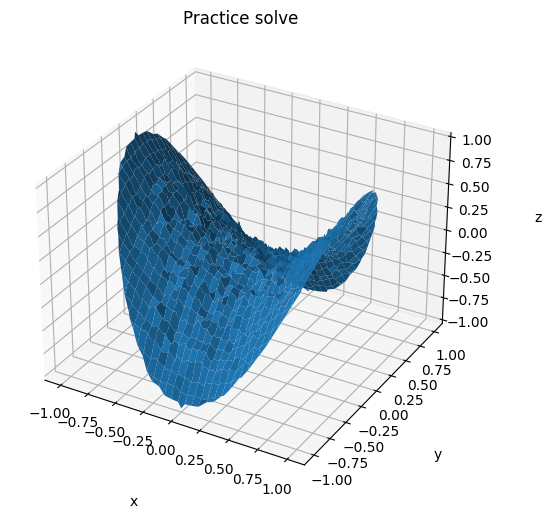

CPU times: user 3min 43s, sys: 2.68 s, total: 3min 46s
Wall time: 3min 43s


In [64]:
%%time
X, Y, Z = LaplaceSolver()

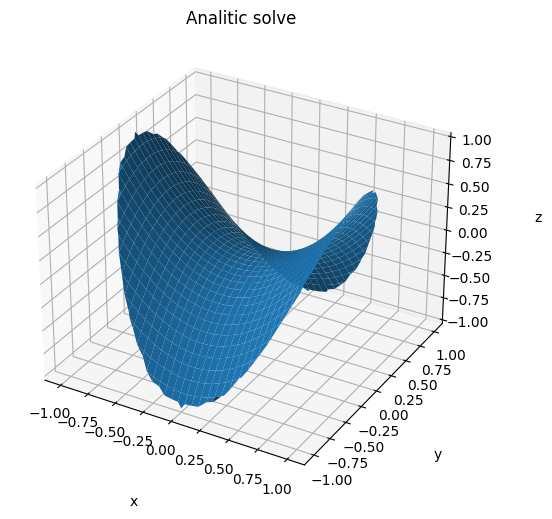

In [65]:
# Аналитическое решение
count_points = 101
x = np.linspace(-1, 1, count_points)
X, Y = np.meshgrid(x, x)
delta = x[1] - x[0]
Z = np.empty(np.shape(X))
Z[X**2 + Y**2 <= 1] = X[X**2 + Y**2 <= 1]**2 - Y[X**2 + Y**2 <= 1]**2
Z[X**2 + Y**2 > 1] = np.NaN

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z)

ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
plt.title('Analitic solve')
plt.show()  

# Задание №9

## Моделирование траектории Винеровского процесса и процесса Орнштейна-Уленбека

In [6]:
def buildSegment(Str, l_bnd, r_bnd, t, W, dt, alpha, sigma, theta):
    if l_bnd + 1 != r_bnd: 
        x_1 = W[l_bnd]
        x_2 = W[r_bnd]
        mid = int((l_bnd + r_bnd) / 2)
        t[mid] = t[l_bnd] + alpha * (t[r_bnd] - t[l_bnd])
        
        if Str == "Wiener":
            mu = (1-alpha)*x_1 + alpha*x_2
            sigma = np.sqrt(alpha * (1-alpha) * dt)
            W[mid] = np.random.normal(mu, sigma)
        else:
            c = np.e**(-theta * dt)
            mu = (x_1+x_2) * np.sqrt(c) / (1 + c)
            disp = sigma**2 / (2*theta) * (1 - c) / (1 + c)
            W[mid] = np.random.normal(mu, np.sqrt(disp))

        buildSegment(Str, mid, r_bnd, t, W, dt * (1-alpha), alpha, sigma, theta)
        buildSegment(Str, l_bnd, mid, t, W, dt * alpha, alpha, sigma, theta)
    

def buildTrajectory(Str, eps=1e-3, alpha=0.5, sigma=4, theta=8):
    n = int(np.log(1/eps) / np.log(1/(1-alpha)))
    l_bnd = 0
    r_bnd = 2**n
    W = np.empty(r_bnd + 1)
    t = np.empty(r_bnd + 1)

    t[0] = 0
    t[-1] = 1
    dt = 1
    if Str == "Wiener":
        W[0] = 0
        W[-1] = np.random.normal(0, 1)
    else:
        disp = sigma**2 / (2*theta)
        W[0] = np.random.normal(0, np.sqrt(disp))
        W[-1] = np.random.normal(W[0]*np.e**(-theta), np.sqrt(disp * (1 - np.e**(-2*theta))))
    
    buildSegment(Str, l_bnd, r_bnd, t, W, dt, alpha, sigma, theta)
    
    return t, W
    
    
def upscaling(Str, eps, t_old, W_old, alpha, sigma=4, theta=8):
    n_old = int(np.log(np.shape(W)[0] - 1) / np.log(2))
    n_new = int(np.log(1/eps) / np.log(1/(1-alpha)))
    
    l_bnd = 0
    r_bnd = 2**n_new
    t_new = np.empty(r_bnd + 1)
    W_new = np.empty(r_bnd + 1)
    t_new[0] = 0
    W_new[0] = W_old[0]
    
    step = 2**(n_new - n_old)
    dt = 1 / 2**n_old
    for i in range(step, r_bnd + 1, step):
        W_new[i] = W_old[int(i / step)]
        t_new[i] = t_old[int(i / step)]
        l_bnd = i - step
        r_bnd = i 
        buildSegment(Str, l_bnd, r_bnd, t_new, W_new, dt, alpha, sigma, theta)
    
    return t_new, W_new

In [7]:
# Построение нескольких траекторий
count = 25
Str = "Wiener"
eps = 1e-3
alpha = 0.4

Text(0.5, 1.0, 'Wiener trajectories')

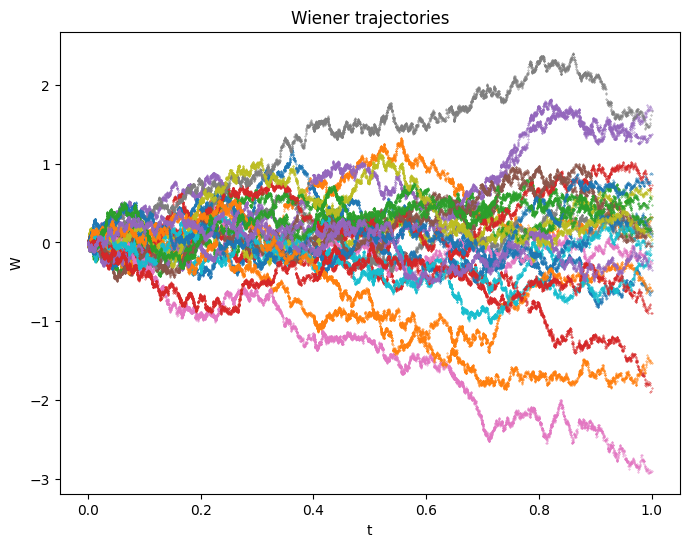

In [8]:
fig = plt.figure(figsize=(8, 6))
for i in range(count):
    t, W = buildTrajectory(Str, eps=eps, alpha=alpha)
    plt.scatter(t, W, s=0.1)
plt.xlabel('t')
plt.ylabel('W')
plt.title(f'{Str} trajectories')

In [9]:
#Демонстрация работы функции upscaling
Str = "Wiener"
eps_1 = 1e-2
eps_2 = 1e-3
alpha = 0.4

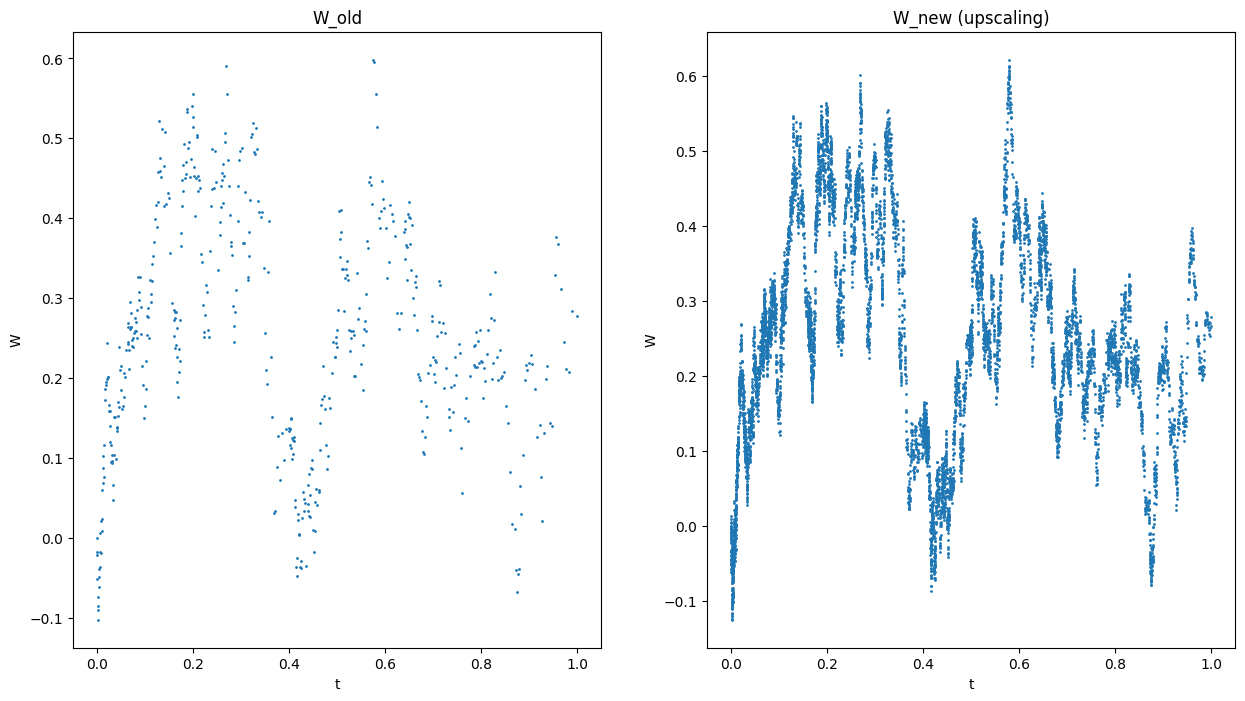

In [10]:
fig = plt.figure(figsize=(15, 8))

t, W = buildTrajectory(Str, eps=eps_1, alpha=alpha)
plt.subplot(1, 2, 1)
plt.xlabel('t')
plt.ylabel('W')
plt.title('W_old')
plt.scatter(t, W, s=1)

t, W = upscaling(Str, eps_2, t, W, alpha=alpha)
plt.subplot(1, 2, 2)
plt.xlabel('t')
plt.ylabel('W')
plt.title('W_new (upscaling)')
plt.scatter(t, W, s=1)

In [11]:
# Построение нескольких траекторий процесса Орнштейна-Уленбека
count = 25
Str = "OU"
eps = 1e-5
alpha = 0.5
sigma = 4
theta = 8

Text(0.5, 1.0, 'OU trajectories')

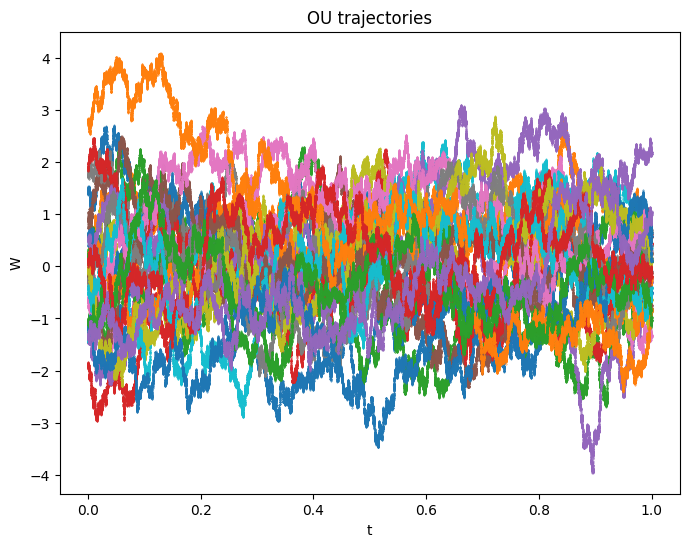

In [12]:
fig = plt.figure(figsize=(8, 6))
for i in range(count):
    t, W = buildTrajectory(Str, eps, alpha, sigma, theta)
    plt.scatter(t, W, s=0.1)
plt.xlabel('t')
plt.ylabel('W')
plt.title(f'{Str} trajectories')

# Задание №10 

## Фильтр Калмана с шумом из нормального распределения

In [14]:
def KalmanFilter(r, sigma, theta, T, Y):
    N = np.size(T)
    x = np.empty(N)
    y = np.empty(N)
    Sigma = np.empty(N)
    
    delta = 1 / (N-1)
    disp = sigma**2 / (2*theta)
    const = np.e**(-theta * delta)

    x[0] = 0
    Sigma[0] = disp
    nu = np.random.normal(0, np.sqrt(disp * (1 - const**2)), N)
    for k in range(1, N):
        x[k] = const * x[k-1] + nu[k]
        Sigma[k] = const**2 * Sigma[k-1] + disp * (1 - const**2)
        K = Sigma[k] / (Sigma[k] + r)
        y[k] = Y[k] + np.random.normal(0, np.sqrt(r))
        x[k] = x[k] + K * (y[k] - x[k])
        Sigma[k] = (1 - K) * Sigma[k]

    return x, y, Sigma

In [13]:
# Строим траекторию реального процесса
Str = "OU"
eps = 1e-6
alpha = 0.5
theta = 4
sigma = 8
T, Y = buildTrajectory(Str, eps, alpha, sigma, theta)

In [15]:
# Фильтрация
x, y, Sigma = KalmanFilter(0.1, 4, 8, T, Y)

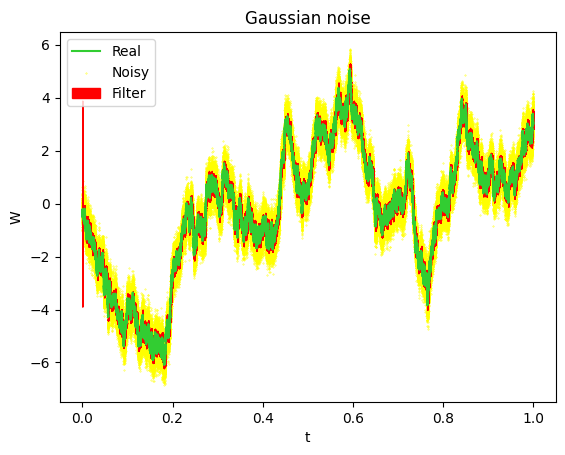

In [16]:
# Визуализация
plt.plot(T, Y, c='limegreen')

t = np.linspace(0, 1, np.size(y))
plt.scatter(t, y, s=0.1, c='yellow')

from scipy.stats import norm 
gamma = 0.9999  #Надёжность
distr = norm(0, 1)
q = distr.ppf((1-gamma)/2)
plt.fill_between(T, x - q*np.sqrt(Sigma), x + q*np.sqrt(Sigma), color='red')

plt.xlabel('t')
plt.ylabel('W')
plt.title('Gaussian noise')
plt.legend(['Real', 'Noisy', 'Filter'])

## Фильтр Калмана с шумом из распределения Коши 

In [37]:
# Фильтрация, берём шум из стандартного распределения Коши
def KalmanFilterCauchy(r, sigma, theta, T, Y):
    N = np.size(T)
    x = np.empty(N)
    y = np.empty(N)
    Sigma = np.empty(N)
    
    delta = 1 / (N-1)
    disp = sigma**2 / (2*theta)
    const = np.e**(-theta * delta)

    x[0] = 0
    Sigma[0] = disp
    nu = np.random.normal(0, np.sqrt(disp * (1 - const**2)), N)
    for k in range(1, N):
        x[k] = const * x[k-1] + nu[k]
        Sigma[k] = const**2 * Sigma[k-1] + disp * (1 - const**2)
        K = Sigma[k] * (Sigma[k] + r) #Значение дисперсии шума Коши r считается известным ?! заранее ?!
        y[k] = Y[k] + np.random.standard_cauchy()
        x[k] = x[k] + K * (y[k] - x[k])
        Sigma[k] = (1 - K) * Sigma[k]

    return x, y, Sigma

In [36]:
# Строим траекторию реального процесса
Str = "OU"
eps = 1e-3
alpha = 0.5
theta = 6
sigma = 18
T, Y = buildTrajectory(Str, eps, alpha, sigma, theta)

In [38]:
x, y, Sigma = KalmanFilterCauchy(0.1, 4, 8, T, Y)

/tmp/ipykernel_5047/2892582230.py:10: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(T, x - q*np.sqrt(Sigma), x + q*np.sqrt(Sigma), color='red')


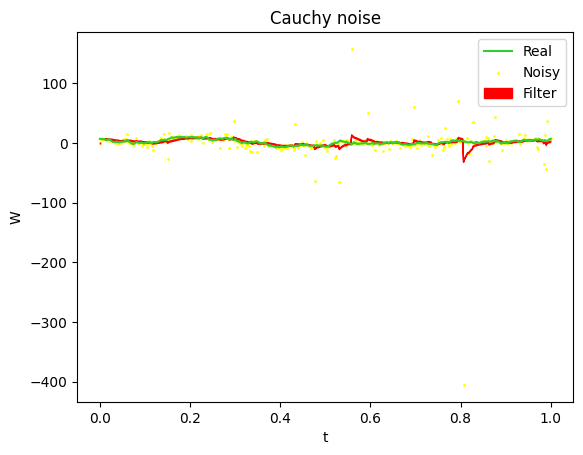

In [39]:
# Визуализация
plt.plot(T, Y, c='limegreen')

t = np.linspace(0, 1, np.size(y))
plt.scatter(t, y, s=1, c='yellow')

gamma = 0.9
distr = norm(0, 1)
q = distr.ppf((1-gamma) / 2) #В данном случае тоже опираемся на тотже доверительный интервал
plt.fill_between(T, x - q*np.sqrt(Sigma), x + q*np.sqrt(Sigma), color='red')

plt.xlabel('t')
plt.ylabel('W')
plt.title('Cauchy noise')
plt.legend(['Real', 'Noisy', 'Filter'])

# Задание №11

## Первая интерпретация: система массового обслуживания

In [ ]:
from scipy.interpolate import interp1d

In [852]:
def QueuingSys(T, lambda_, nums=10001):
    # События
    T_start = []
    t = 0
    while t <= T:
        T_start.append(t)
        t += np.random.exponential(1 / lambda_)

    # Время обработки
    s = np.random.normal(0, 1, (10, len(T_start)))**2
    s = np.sum(s, axis=0)

    # Время окончания обработки
    T_end = [s[0]]
    i = 0
    sz = np.size(T_start) - 1
    while i < sz and T_end[i] <= T:
        i += 1
        T_end.append(T_start[i] + s[i] + max(T_end[i-1] - T_start[i], 0))
    if i < sz:
        T_end.pop()

    # Подсчёт очереди
    ptr_1 = 0
    ptr_2 = 0
    count = 0
    k = 0
    cnt = np.empty(len(T_start) + len(T_end))
    while (ptr_1 < len(T_start)) and (ptr_2 < len(T_end)):
        if T_start[ptr_1] <= T_end[ptr_2]:
            ptr_1 += 1
            count += 1
        else:
            ptr_2 += 1
            count -= 1

        cnt[k] = count
        k += 1

    # Для удобства интерполяции 
    tm = np.sort(T_start + T_end)[:k]
    tm = np.insert(tm, k, T)
    cnt = cnt[:k]
    cnt = np.insert(cnt, k, cnt[-1])
    
    # Визуализация
    g = interp1d(tm, cnt, kind='previous')
    x = np.linspace(0, T, nums)
    y = g(x)
    plt.plot(x, y)
    plt.xlabel('t')
    plt.ylabel('Queue')
    plt.title(f'T = {T}, lambda_ = {lambda_}')
    
    return tm, cnt

### Очередь рассасывается

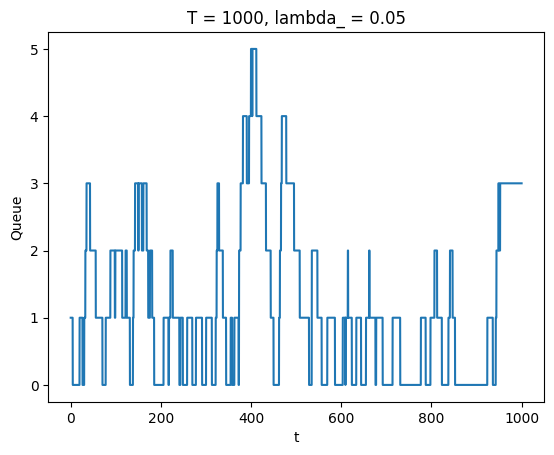

In [853]:
_, _ = QueuingSys(1000, 0.05, nums=10001)

### Очередь меняется не сильно 

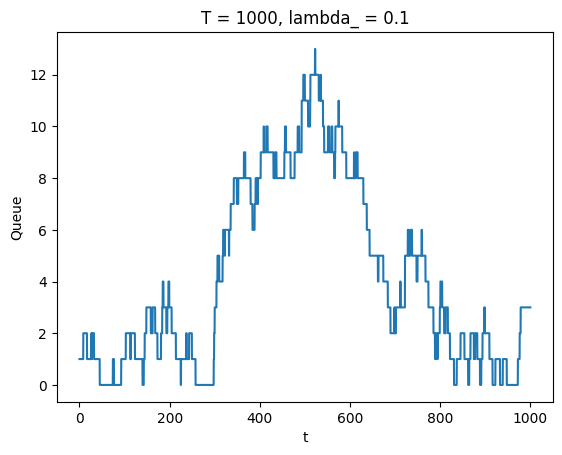

In [854]:
_, _ = QueuingSys(1000, 0.1, nums=10001)

### Очередь растёт

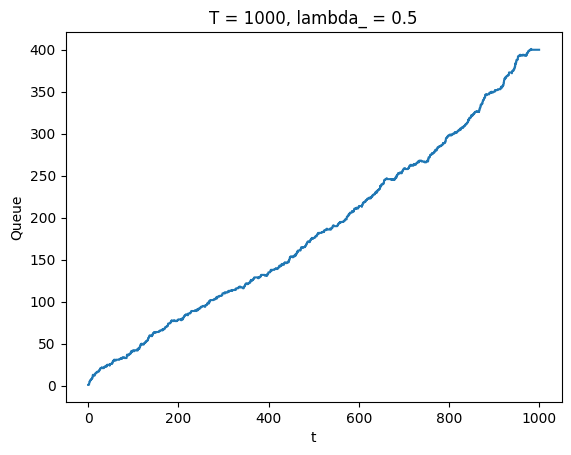

In [855]:
_, _ = QueuingSys(1000, 0.5, nums=10001)

## Вторая интерпретация: система массового обслуживания с циклической интенсивностью и единичными скачками

In [802]:
def NonhomogeneousPoiss(lambda_0=5, T=100): 
    # События
    T_event = []
    t = 0
    while t <= T:
        t += np.random.exponential(1 / (2*lambda_0))
        if np.random.choice([0, 1], p=[(1-np.cos(t)) / 2, (1+np.cos(t)) / 2]):
            T_event.append(t)
    T_event.pop()

    # Визуализация
    plt.plot(T_event, np.arange(1, np.size(T_event)+1), label='Nonhomogeneous poiss')
    plt.plot(T_event, lambda_0 * (1+np.cos(T_event)), label='lambda(t)')
    plt.xlabel('t')
    plt.ylabel('N')
    plt.title(f'lambda_0 = {lambda_0}, T = {T}')
    plt.legend()
    
    return T_event

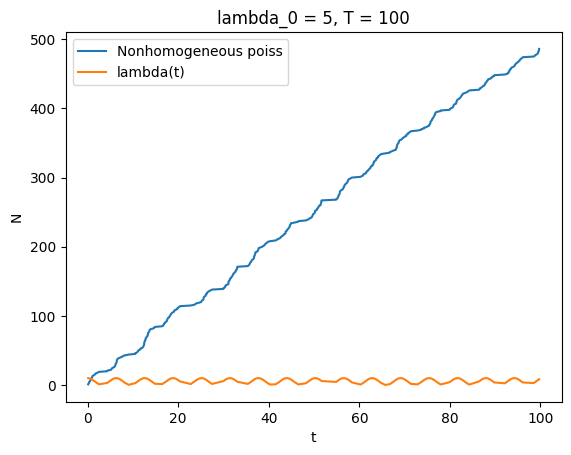

In [803]:
_ = NonhomogeneousPoiss()

## Третья интерпретация: работа страховой компании

In [817]:
def InsuranceComp(T, lambda_, x_m, k, W_0, c, nums=100001):
    # События
    T_start = []
    t = 0
    while t <= T:
        T_start.append(t)
        t += np.random.exponential(1 / lambda_)
        
    # Убытки
    ksi = np.random.uniform(0, 1, len(T_start))
    s = x_m * ksi**(-1/k)
    
    t = np.linspace(0, T, nums)
    s = np.cumsum(s)
    W = np.empty(np.shape(t))
    
    # Капитал
    for i in range(1, len(T_start)):
        W[(T_start[i-1] <= t) & (t < T_start[i])] = W_0 + c*t[(T_start[i-1] <= t) & (t < T_start[i])] - s[i-1]
    W[t >= T_start[-1]] = W_0 + c*t[t >= T_start[-1]] - s[-1]

    # Визуализация 
    plt.plot(t, W)
    plt.xlabel('t')
    plt.ylabel('W')
    plt.title(f'T = {T}, lambda_ = {lambda_}, x_m = {x_m}, k = {k}, W_0 = {W_0}, c = {c}')
    
    return t, W

### Капитал убывает

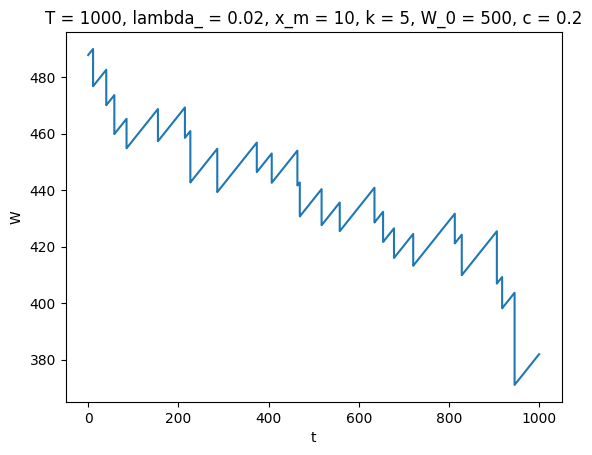

In [821]:
_, _ = InsuranceComp(1000, 0.02, 10, 5, 500, 0.2)

### Капитал в равновесии

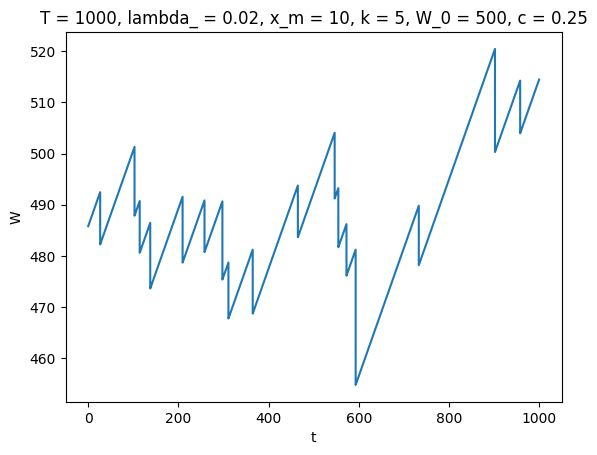

In [827]:
_, _ = InsuranceComp(1000, 0.02, 10, 5, 500, 0.25)

### Капитал возрастает 

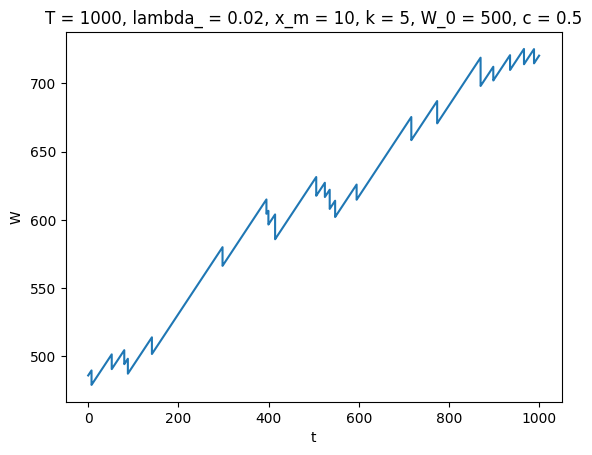

In [830]:
_, _ = InsuranceComp(1000, 0.02, 10, 5, 500, 0.5)